In [1]:
import numpy as np
import os
import pandas as pd
from scipy.stats import gaussian_kde

import matplotlib as mpl
mpl.use('Agg')

mpl.rcParams['figure.figsize'] = (7,7)
mpl.rcParams['figure.facecolor'] = (1,1,1,1)
mpl.rcParams.update({'font.size':22})

% matplotlib inline

import matplotlib.pyplot as plt

In [2]:
import keras

Using Theano backend.


In [3]:
wdir = '/home/mho1/scratch/halo_cnn'

In [4]:
from tools.catalog import Catalog

# Load Trained Models

In [5]:
model_1d_num = 152
model_2d_num =  67

In [18]:
# Load keras models

model_1d = [None]*10
model_2d = [None]*10

for i in range(10):
    print('fold:',i)
    
    model_1d[i] = keras.models.load_model('/home/mho1/scratch/halo_cnn/saved_models/halo_cnn1d_r/halo_cnn1d_r_' + \
                                           str(model_1d_num)+'/models/fold_'+str(i)+'.h5')
    model_2d[i] = keras.models.load_model('/home/mho1/scratch/halo_cnn/saved_models/halo_cnn2d_r/halo_cnn2d_r_' + \
                                           str(model_2d_num)+'/models/fold_'+str(i)+'.h5')

model_1d_np = keras.models.load_model('/home/mho1/scratch/halo_cnn/saved_models/halo_cnn1d_r/halo_cnn1d_r_' + \
                                           str(153)+'/models/fold_'+str(0)+'.h5')
model_2d_np = keras.models.load_model('/home/mho1/scratch/halo_cnn/saved_models/halo_cnn2d_r/halo_cnn2d_r_' + \
                                      str(72)+'/models/fold_'+str(0)+'.h5')

fold: 0


/home/mho1/scratch/anaconda3/envs/jupy/lib/python3.6/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


fold: 1
fold: 2
fold: 3
fold: 4
fold: 5
fold: 6
fold: 7
fold: 8
fold: 9


In [11]:
# Load params

par_1d = np.load('/home/mho1/scratch/halo_cnn/saved_models/halo_cnn1d_r/halo_cnn1d_r_' + \
                 str(model_1d_num)+'/halo_cnn1d_r_' + \
                 str(model_1d_num) + '.npy',
                 encoding='latin1').item()['params']

par_2d = np.load('/home/mho1/scratch/halo_cnn/saved_models/halo_cnn2d_r/halo_cnn2d_r_' + \
                 str(model_2d_num)+'/halo_cnn2d_r_' + \
                 str(model_2d_num) + '.npy',
                 encoding='latin1').item()['params']

def logM_from_y1d(y):
    return (par_1d['logmass_max'] - par_1d['logmass_min'])*y + par_1d['logmass_min']
def logM_from_y2d(y):
    return (par_2d['logmass_max'] - par_2d['logmass_min'])*y + par_2d['logmass_min']

# Load Catalog

In [12]:
cat_med = Catalog().load(os.path.join(wdir,'data_mocks','Rockstar_UM_z=0.117_contam_med.p'))
cat_lar = Catalog().load(os.path.join(wdir,'data_mocks','Rockstar_UM_z=0.117_contam_large.p'))

Loading catalog from: /home/mho1/scratch/halo_cnn/data_mocks/Rockstar_UM_z=0.117_contam_med.p
Loading catalog from: /home/mho1/scratch/halo_cnn/data_mocks/Rockstar_UM_z=0.117_contam_large.p


In [13]:
vcut = cat_med.par['vcut']
aperture = cat_med.par['aperture']

In [14]:
# Create test catalog

bin_edges = np.linspace(14,15.2, 35)
test_ind = []

for i in range(len(bin_edges)-1):
    test_ind += list( np.random.choice( np.argwhere( (cat_lar.prop['M200c']>10**bin_edges[i]) & \
                                                     (cat_lar.prop['M200c']<10**bin_edges[i+1])
                                                   ).flatten(), 5, replace=False ) )

# Calculate shift error

In [15]:
def cylinder_cut(gals, offset = (0,0)):
    
    members = (np.abs(gals['vlos'] - offset[0]) < vcut) & \
              ((gals['Rproj']-offset[1]) < aperture) & \
              ((gals['Rproj']-offset[1]) > 0)
    
    return gals[members]

def kde_1d(gals, offset=0):
    shape = (48,1)
    bwidth = 0.25
    vcut = 2500. # [km/s]
    
    # Check for derived quantities
    if (np.sum(gals['vlos']==0)!=0):
        warnings.warn('Zero vlos. Check if derived quantities have been updated.')
    
    v_pos = np.linspace(-vcut + offset ,vcut + offset, shape[0]+1)
    sample = [np.mean(v_pos[[i,i+1]]) for i in range(len(v_pos)-1)]
    
    kde = gaussian_kde(gals['vlos'], bwidth)
    
    kdeval = kde(sample).T
    kdeval /= kdeval.sum()
    
    return kdeval.reshape(1,*shape)

def kde_2d(gals, offset = (0,0)):
    shape=(48,48)
    bwidth=0.25
    vcut = 2500. # [km/s]
    aperture = 1.6 # [Mpc/h]
    
    v_pos = np.linspace(-vcut + offset[0], vcut + offset[0], shape[0] + 1)
    a_pos = np.linspace(0 + offset[1], aperture + offset[1], shape[1] + 1)
    v_pos = [np.mean(v_pos[[i,i+1]]) for i in range(len(v_pos)-1)]
    a_pos = [np.mean(a_pos[[i,i+1]]) for i in range(len(a_pos)-1)]

    mesh = np.meshgrid(a_pos,v_pos)
    mesh = np.flip(mesh,0)
    sample = np.vstack([mesh[0].ravel(), mesh[1].ravel()])
    
    
    kde = gaussian_kde((gals['vlos'],gals['Rproj']), bwidth)
    
    kdeval = np.reshape(kde(sample).T, mesh[0].shape)
    kdeval /= kdeval.sum()
    
    return kdeval.reshape(1,*shape)

## 1D

In [52]:
fold = 0


# Determining baseline
logM_pred0_p = np.zeros(len(test_ind))
logM_pred0_np = np.zeros(len(test_ind))

for k in range(len(test_ind)):
    gals = cylinder_cut(cat_lar.gal[test_ind[k]])

    kdeval_1d = kde_1d(gals)

    logM_pred0_p[k] = logM_from_y1d(model_1d[fold].predict(kdeval_1d)).flatten()[0]
    logM_pred0_np[k] = logM_from_y1d(model_1d_np.predict(kdeval_1d)).flatten()[0]

    
# Determining offset predictions
diff_1d_p = np.zeros(shape=(48,))
diff_1d_np = np.zeros(shape=(48,))

for i in range(0,48):
    print(i)

    vlos_offset = (i-24)*(2*vcut)/48

    offset = (vlos_offset,0)

    logM_pred_p = np.zeros(len(test_ind))
    logM_pred_np = np.zeros(len(test_ind))

    for k in range(len(test_ind)):
        gals = cylinder_cut(cat_lar.gal[test_ind[k]], offset = offset)

        if len(gals)<3:
            continue

        kdeval_1d = kde_1d(gals, offset=offset[0])

        logM_pred_p[k] = logM_from_y1d(model_1d[fold].predict(kdeval_1d)).flatten()[0]
        logM_pred_np[k] = logM_from_y1d(model_1d_np.predict(kdeval_1d)).flatten()[0]

    diff_1d_p[i] = np.mean((logM_pred_p-logM_pred0_p)**2)
    diff_1d_np[i] = np.mean((logM_pred_np-logM_pred0_np)**2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


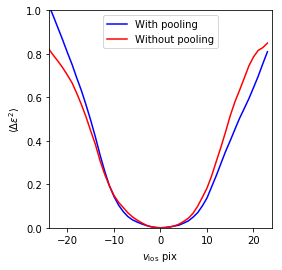

In [70]:
f = plt.figure(figsize=[4,4])

plt.plot(np.arange(-24,24), diff_1d_p,'b', label='With pooling')
plt.plot(np.arange(-24,24), diff_1d_np,'r', label='Without pooling')

plt.xlim(-24,24)
plt.ylim(0,1)
plt.xlabel('$v_\mathrm{los}$ pix')
plt.ylabel(r'$\langle\Delta\epsilon^2\rangle$')

plt.legend()

## 2D

In [36]:
fold = 0


# Determining baseline
logM_pred0_p = np.zeros(len(test_ind))
logM_pred0_np = np.zeros(len(test_ind))

for k in range(len(test_ind)):
    gals = cylinder_cut(cat_lar.gal[test_ind[k]])

    kdeval_2d = kde_2d(gals)

    logM_pred0_p[k] = logM_from_y2d(model_2d[fold].predict(kdeval_2d)).flatten()[0]
    logM_pred0_np[k] = logM_from_y2d(model_2d_np.predict(kdeval_2d)).flatten()[0]

    
# Determining offset predictions
diff_2d_p = np.zeros(shape=(48,48))
diff_2d_np = np.zeros(shape=(48,48))

for i in range(0,48):
    for j in range(48):
        print((i,j))
        
        vlos_offset = (i-24)*(2*vcut)/48
        Rproj_offset = j*aperture/48
        
        offset = (vlos_offset, Rproj_offset)
        
        logM_pred_p = np.zeros(len(test_ind))
        logM_pred_np = np.zeros(len(test_ind))
        
        for k in range(len(test_ind)):
            gals = cylinder_cut(cat_lar.gal[test_ind[k]], offset = offset)
            
            if len(gals)<3:
                continue
            
            kdeval_2d = kde_2d(gals, offset=offset)
            
            logM_pred_p[k] = logM_from_y2d(model_2d[fold].predict(kdeval_2d)).flatten()[0]
            logM_pred_np[k] = logM_from_y2d(model_2d_np.predict(kdeval_2d)).flatten()[0]
        
        diff_2d_p[i,j] = np.mean((logM_pred_p-logM_pred0_p)**2)
        diff_2d_np[i,j] = np.mean((logM_pred_np-logM_pred0_np)**2)

(0, 0)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(0, 7)
(0, 8)
(0, 9)
(0, 10)
(0, 11)
(0, 12)
(0, 13)
(0, 14)
(0, 15)
(0, 16)
(0, 17)
(0, 18)
(0, 19)
(0, 20)
(0, 21)
(0, 22)
(0, 23)
(0, 24)
(0, 25)
(0, 26)
(0, 27)
(0, 28)
(0, 29)
(0, 30)
(0, 31)
(0, 32)
(0, 33)
(0, 34)
(0, 35)
(0, 36)
(0, 37)
(0, 38)
(0, 39)
(0, 40)
(0, 41)
(0, 42)
(0, 43)
(0, 44)
(0, 45)
(0, 46)
(0, 47)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(1, 10)
(1, 11)
(1, 12)
(1, 13)
(1, 14)
(1, 15)
(1, 16)
(1, 17)
(1, 18)
(1, 19)
(1, 20)
(1, 21)
(1, 22)
(1, 23)
(1, 24)
(1, 25)
(1, 26)
(1, 27)
(1, 28)
(1, 29)
(1, 30)
(1, 31)
(1, 32)
(1, 33)
(1, 34)
(1, 35)
(1, 36)
(1, 37)
(1, 38)
(1, 39)
(1, 40)
(1, 41)
(1, 42)
(1, 43)
(1, 44)
(1, 45)
(1, 46)
(1, 47)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(2, 10)
(2, 11)
(2, 12)
(2, 13)
(2, 14)
(2, 15)
(2, 16)
(2, 17)
(2, 18)
(2, 19)
(2, 20)
(2, 21)
(2, 22)
(2, 23)
(2, 24)
(2, 25)
(2, 26)
(2, 27)
(2, 28)
(2, 29)
(2, 30)
(2, 31)
(2, 32

(20, 27)
(20, 28)
(20, 29)
(20, 30)
(20, 31)
(20, 32)
(20, 33)
(20, 34)
(20, 35)
(20, 36)
(20, 37)
(20, 38)
(20, 39)
(20, 40)
(20, 41)
(20, 42)
(20, 43)
(20, 44)
(20, 45)
(20, 46)
(20, 47)
(21, 0)
(21, 1)
(21, 2)
(21, 3)
(21, 4)
(21, 5)
(21, 6)
(21, 7)
(21, 8)
(21, 9)
(21, 10)
(21, 11)
(21, 12)
(21, 13)
(21, 14)
(21, 15)
(21, 16)
(21, 17)
(21, 18)
(21, 19)
(21, 20)
(21, 21)
(21, 22)
(21, 23)
(21, 24)
(21, 25)
(21, 26)
(21, 27)
(21, 28)
(21, 29)
(21, 30)
(21, 31)
(21, 32)
(21, 33)
(21, 34)
(21, 35)
(21, 36)
(21, 37)
(21, 38)
(21, 39)
(21, 40)
(21, 41)
(21, 42)
(21, 43)
(21, 44)
(21, 45)
(21, 46)
(21, 47)
(22, 0)
(22, 1)
(22, 2)
(22, 3)
(22, 4)
(22, 5)
(22, 6)
(22, 7)
(22, 8)
(22, 9)
(22, 10)
(22, 11)
(22, 12)
(22, 13)
(22, 14)
(22, 15)
(22, 16)
(22, 17)
(22, 18)
(22, 19)
(22, 20)
(22, 21)
(22, 22)
(22, 23)
(22, 24)
(22, 25)
(22, 26)
(22, 27)
(22, 28)
(22, 29)
(22, 30)
(22, 31)
(22, 32)
(22, 33)
(22, 34)
(22, 35)
(22, 36)
(22, 37)
(22, 38)
(22, 39)
(22, 40)
(22, 41)
(22, 42)
(22, 43)
(22

(39, 47)
(40, 0)
(40, 1)
(40, 2)
(40, 3)
(40, 4)
(40, 5)
(40, 6)
(40, 7)
(40, 8)
(40, 9)
(40, 10)
(40, 11)
(40, 12)
(40, 13)
(40, 14)
(40, 15)
(40, 16)
(40, 17)
(40, 18)
(40, 19)
(40, 20)
(40, 21)
(40, 22)
(40, 23)
(40, 24)
(40, 25)
(40, 26)
(40, 27)
(40, 28)
(40, 29)
(40, 30)
(40, 31)
(40, 32)
(40, 33)
(40, 34)
(40, 35)
(40, 36)
(40, 37)
(40, 38)
(40, 39)
(40, 40)
(40, 41)
(40, 42)
(40, 43)
(40, 44)
(40, 45)
(40, 46)
(40, 47)
(41, 0)
(41, 1)
(41, 2)
(41, 3)
(41, 4)
(41, 5)
(41, 6)
(41, 7)
(41, 8)
(41, 9)
(41, 10)
(41, 11)
(41, 12)
(41, 13)
(41, 14)
(41, 15)
(41, 16)
(41, 17)
(41, 18)
(41, 19)
(41, 20)
(41, 21)
(41, 22)
(41, 23)
(41, 24)
(41, 25)
(41, 26)
(41, 27)
(41, 28)
(41, 29)
(41, 30)
(41, 31)
(41, 32)
(41, 33)
(41, 34)
(41, 35)
(41, 36)
(41, 37)
(41, 38)
(41, 39)
(41, 40)
(41, 41)
(41, 42)
(41, 43)
(41, 44)
(41, 45)
(41, 46)
(41, 47)
(42, 0)
(42, 1)
(42, 2)
(42, 3)
(42, 4)
(42, 5)
(42, 6)
(42, 7)
(42, 8)
(42, 9)
(42, 10)
(42, 11)
(42, 12)
(42, 13)
(42, 14)
(42, 15)
(42, 16)
(42,

In [51]:
np.save(os.path.join(wdir,'temp','diff_2d_p.npy'), diff_2d_p)
np.save(os.path.join(wdir,'temp','diff_2d_np.npy'), diff_2d_np)

diff_2d_p_temp = np.load(os.path.join(wdir,'temp','diff_2d_p.npy'))
diff_2d_np_temp = np.load(os.path.join(wdir,'temp','diff_2d_np.npy'))

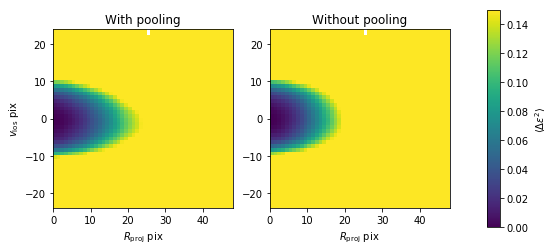

In [43]:
f = plt.figure(figsize=[8,4])
gs = mpl.gridspec.GridSpec(1,3, wspace=0.3,width_ratios=[7,7,0.5])


ax1 = f.add_subplot(gs[0,0])

im = ax1.imshow(diff_2d_p, extent=[0,48,-24,24], vmin=0, vmax=0.15)

ax1.set_title('With pooling')
ax1.set_xlabel('$R_\mathrm{proj}$ pix')
ax1.set_ylabel('$v_\mathrm{los}$ pix')

ax2 = f.add_subplot(gs[0,1])

im = ax2.imshow(diff_2d_np, extent=[0,48,-24,24], vmin=0, vmax=0.15)

ax2.set_xlabel('$R_\mathrm{proj}$ pix')
ax2.set_title('Without pooling')


ax3 = f.add_subplot(gs[0,2])
plt.colorbar(im,cax=ax3,label=r'$\langle\Delta\epsilon^2\rangle$')